In [1]:
# import dependencies
%load_ext lab_black
%matplotlib inline

from matplotlib import style
style.use("fivethirtyeight")

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Find the latest date in the dataset
latest_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).all()
latest_date = latest_date[0][0]
latest_date

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The date 1 year ago: {year_ago_date}")

The date 1 year ago: 2016-08-23


In [12]:
# Perform a query to retrieve the last 12 months of precipitation data
year_prcp_data = (
    session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp)
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago_date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
year_prcp_df = pd.DataFrame(year_prcp_data, columns=["date", "precipitation"])
year_prcp_df.set_index("date", inplace=True)

# Sort the dataframe by date
year_prcp_df.sort_values("date", ascending=True)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


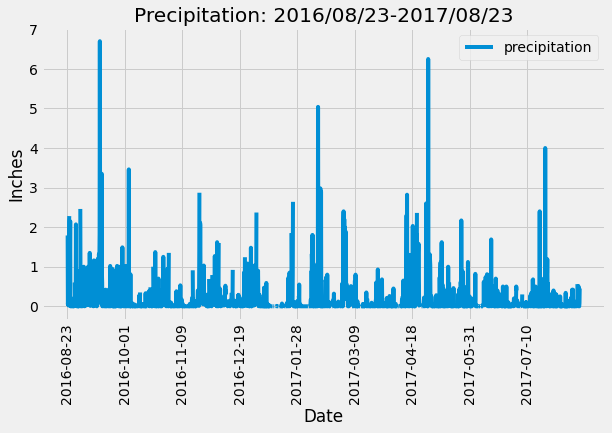

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df_matplot = year_prcp_df.sort_values("date", ascending=True).reset_index()

df_matplot.plot(
    x="date",
    xticks=(0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000),
    y="precipitation",
    title="Precipitation: 2016/08/23-2017/08/23",
    label="precipitation",
    rot=90,
    figsize=(9, 5),
)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()
plt.tight_layout()
plt.savefig("Images/sabrina_precipitation.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).distinct().count()
print(f"Number of Stations: {station_count}")

Number of Stations: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
station_active_most = station_active[0][0]

temps = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == station_active_most)
    .all()
)

print(f"Lowest temperature of active station: {temps[0][0]} fahrenheit")
print(f"Highest temperature of active station: {temps[0][1]} fahrenheit")
print(f"Average temperature of active station: {round(temps[0][2], 2)} fahrenheit")

Lowest temperature of active station: 54.0 fahrenheit
Highest temperature of active station: 85.0 fahrenheit
Average temperature of active station: 71.66 fahrenheit


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_tobs_data = (
    session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.tobs)
    .filter(Measurement.station == station_active_most)
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago_date)
    .all()
)

# save as a data frame
active_tobs_df = pd.DataFrame(active_tobs_data, columns=["date", "tobs"])
active_tobs_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


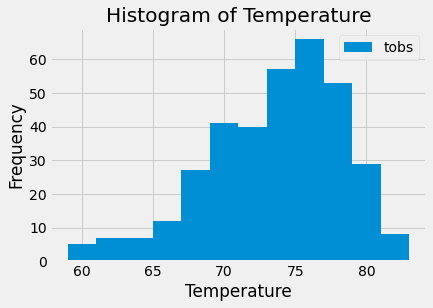

In [19]:
# plot the results as a histogram
active_tobs_df.plot(kind="hist", bins=12)
plt.title("Histogram of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Images/sabrina_station-histogram.png")
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps("2017-01-04", "2017-01-18")

print(f"Lowest temperature during my trip: {trip_temps[0][0]} fahrenheit")
print(f"Average temperature during my trip: {round(trip_temps[0][1], 2)} fahrenheit")
print(f"Highest temperature during my trip: {trip_temps[0][2]} fahrenheit")

Lowest temperature during my trip: 60.0 fahrenheit
Average temperature during my trip: 69.26 fahrenheit
Highest temperature during my trip: 81.0 fahrenheit


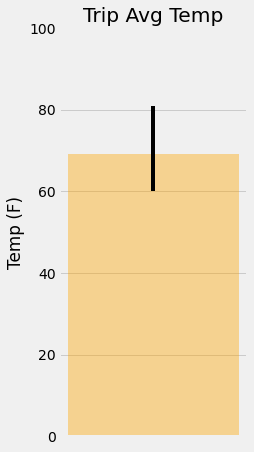

In [22]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp
errorBars = np.array([[min_error], [max_error]])

plt.figure(figsize=(3, 7))
plt.bar(0, avg_temp, yerr=errorBars, color="orange", alpha=0.4)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0, 100)
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/sabrina_temperature.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Find previous year's matching dates for trip dates
start_date_match = "2017-01-04"
end_date_match = "2017-01-18"

# query for precipitation per station on trip dates
sel = [
    Station.station,
    Station.name,
    func.sum(Measurement.prcp),
    Station.latitude,
    Station.longitude,
    Station.elevation,
]

station_rain = (
    session.query(*sel)
    .filter(Station.station == Measurement.station)
    .filter(Measurement.date >= start_date_match)
    .filter(Measurement.date <= end_date_match)
    .group_by(Station.station)
    .order_by(func.sum(Measurement.prcp).desc())
    .all()
)

# convert query object to data frame
station_rain_df = pd.DataFrame(np.array(station_rain))

# rename columns
station_rain_df = station_rain_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Total Precipitation",
        3: "Latitude",
        4: "Longitude",
        5: "Elevation",
    }
)

station_rain_df

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.6799999999999999,21.3331,-157.8025,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.62,21.5213,-157.8374,7.0
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.61,21.33556,-157.71139,19.5
3,USC00519281,"WAIHEE 837.5, HI US",0.17,21.45167,-157.84888999999998,32.9
4,USC00513117,"KANEOHE 838.1, HI US",0.06,21.4234,-157.8015,14.6
5,USC00519397,"WAIKIKI 717.2, HI US",0.0,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


In [24]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2021-01-04"
end_date = "2021-01-18"

# Use the start and end date to create a range of dates
start_num = int(start_date[-2:])
end_num = int(end_date[-2:])
trip_length = end_num - start_num + 1

start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")

# Stip off the year and save a list of %m-%d strings
date_list = [
    dt.datetime.strftime(start_date + dt.timedelta(days=x), "%m-%d")
    for x in range(0, trip_length)
]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in date_list]

normals

[[(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)],
 [(57.0, 67.25454545454545, 77.0)],
 [(58.0, 69.52631578947368, 77.0)],
 [(56.0, 69.31372549019608, 78.0)],
 [(54.0, 68.62962962962963, 80.0)],
 [(61.0, 69.07407407407408, 76.0)],
 [(57.0, 68.63157894736842, 77.0)]]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_normals = [np.array(normal[0]) for normal in normals]

normals_df = pd.DataFrame(trip_normals)

# Add date column
normals_df["Date"] = date_list

# Rename other columns
normals_df = normals_df.rename(columns={0: "tmin", 1: "tavg", 2: "tmax"})

# Set index for date
normals_df = normals_df.set_index("Date")
normals_df

,tmin,tavg,tmax
Date,,,
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0
01-10,62.0,69.741379,77.0
01-11,57.0,67.310345,78.0
01-12,57.0,67.407407,81.0


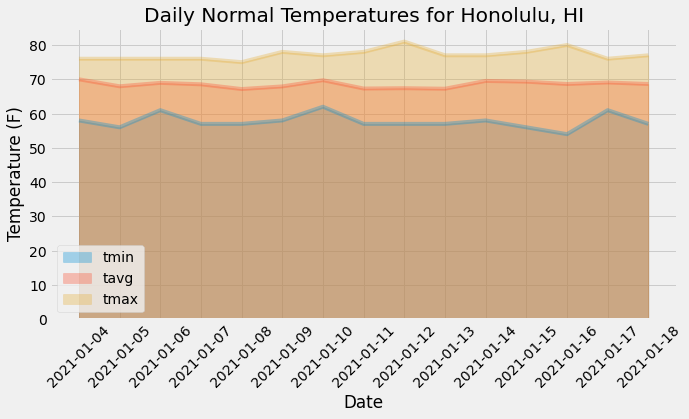

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates = [
    "01-04",
    "01-05",
    "01-06",
    "01-07",
    "01-08",
    "01-09",
    "01-10",
    "01-11",
    "01-12",
    "01-13",
    "01-14",
    "01-15",
    "01-16",
    "01-17",
    "01-18",
]

fig, ax = plt.subplots(figsize=(10, 5))
normals_df.plot.area(ax=ax, stacked=False, alpha=0.333)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")
ax.set_title("Daily Normal Temperatures for Honolulu, HI")
dates = [f"2021-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation=45)
plt.tight_layout()
plt.savefig("Images/sabrina_daily-normals.png")
plt.show()